# Setting Up YOLO object detector for cytology

In [2]:
import cv2
import numpy as np
import tensorflow as tf
import time
import yolov4
from yolov4.tf import YOLOv4
import pandas as pd
import os 


yolo = YOLOv4()
yolo.classes = "/yolo_weights/obj.names"
yolo.make_model()
yolo.load_weights("/yolo_weights/yolo-obj_best.weights",
                  weights_type="yolo")

columns = ["x", "y", "width", "height", "type", "probablty"]

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [19]:
yolo.classes

{0: 'Neutrophil',
 1: 'Metamyelocyte',
 2: 'Myelocyte',
 3: 'Promyelocyte',
 4: 'Blast',
 5: 'Erythroblast',
 6: 'Megakaryocyte_nucleus',
 7: 'Lymphocyte',
 8: 'Monocyte',
 9: 'Plasma_cell',
 10: 'Eosinophil',
 11: 'Basophil',
 12: 'Megakaryocyte',
 13: 'Other_cell',
 14: 'Debris',
 15: 'Histiocyte',
 16: 'Platelet',
 17: 'Platelet_clump',
 18: 'Mast_cell'}

## Read a sample patch

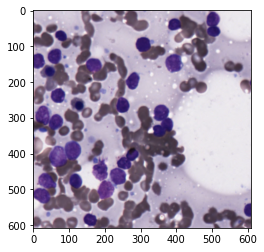

In [40]:
import matplotlib.pyplot as plt

#address to a sample BMA patch
patch_address = "......"

original_image = cv2.imread(patch_address)
resized_image = tf.image.resize(resized_image, (608, 608))
resized_image = np.array(resized_image)
resized_image = resized_image / 255
input_data = resized_image[np.newaxis, ...].astype(np.float32)

plt.imshow(resized_image)

In [51]:
resized_image.shape, resized_image_x.shape

((608, 608, 3), (608, 608, 3))

## YOLO's cell type classification

time: 79.82 ms


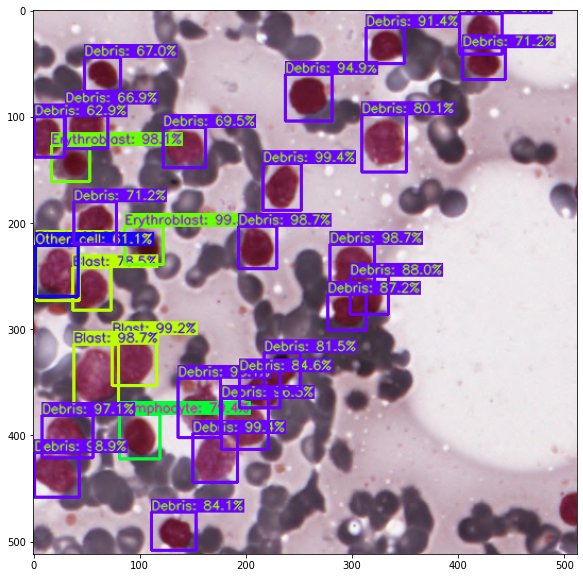

In [41]:
start_time = time.time()
candidates = yolo.model.predict(input_data)
_candidates = []
for candidate in candidates:
    batch_size = candidate.shape[0]
    grid_size = candidate.shape[1]
    _candidates.append(
        tf.reshape(
            candidate, shape=(1, grid_size * grid_size * 3, -1)
        )
    )

candidates = np.concatenate(_candidates, axis=1)
pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0])
pred_bboxes = yolo.fit_pred_bboxes_to_original(
    pred_bboxes, original_image.shape
)
exec_time = time.time() - start_time
print("time: {:.2f} ms".format(exec_time * 1000))
result = yolo.draw_bboxes(original_image, pred_bboxes)

plt.figure(figsize=(10,10))
plt.imshow(result)

## Sample Panda's DataFrame for YOLO's predictions.

In [12]:
columns = ["x", "y", "width", "height", "type", "probablty"]


pd.DataFrame(pred_bboxes, columns=columns)

,x,y,width,height,type,probablty
0,0.292761,0.006330,0.043619,0.011789,16.0,0.786114
1,0.602212,0.661291,0.031604,0.031702,16.0,0.275191
2,0.609354,0.860480,0.039986,0.044075,17.0,0.411778
3,0.636418,0.330460,0.081339,0.090040,5.0,0.994298


## Iterating over a set of patches and store YOLO's predictions

In [ ]:
#define the directory for patches
patch_directory = "...."
patches = os.listdir(patch_directory)

In [42]:
#CD to the patch_directory
os.chdir(patch_direcotory)

#new path for predictions
new_path = "yolo_predictions" 
if not os.path.exists(new_path):
    os.makedirs(new_path)

for patch in patches:
    
    original_image = cv2.imread(patch)
    resized_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    resized_image = tf.image.resize(resized_image, (608, 608))
    resized_image = np.array(resized_image)
    resized_image = resized_image / 255
    input_data = resized_image[np.newaxis, ...].astype(np.float32)

    candidates = yolo.model.predict(input_data)
    _candidates = []
    for candidate in candidates:
        batch_size = candidate.shape[0]
        grid_size = candidate.shape[1]
        _candidates.append(
            tf.reshape(
                candidate, shape=(1, grid_size * grid_size * 3, -1)
            )
        )

    candidates = np.concatenate(_candidates, axis=1)
    pred_bboxes = yolo.candidates_to_pred_bboxes(candidates[0])
    pred_bboxes = yolo.fit_pred_bboxes_to_original(
        pred_bboxes, original_image.shape
    )
    
        
    predictions = pd.DataFrame(pred_bboxes, columns=columns)
    
    #store each patch's prediction
    file_loc = os.path.join(new_path, patch[:-4] + ".csv")
    predictions.to_csv(file_loc)